<a href="https://colab.research.google.com/github/64060kbarot/AML_64061/blob/main/Assignment_Weather_Time_Series_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Assignment 3 Weather Time Series Forcasting Using RNN architecture***

*Use any or all of the methods we discussed in class to improve weather time-series forecasting problems discussed in class. These methods can include:*

*1.Adjusting the number of units in each recurrent layer in the stacked setup*

*2.Using layer_lstm() instead of layer_gru().*

*3.Using a combination of 1d_convnets and RNN.*



In [22]:
#Data Upload from amazon Web Services (AWS) /keras
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2024-07-20 18:33:29--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.236.8, 16.182.102.224, 52.217.86.222, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.236.8|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip.2’

jena_climate_2009_2 100%[===================>]  12.94M  45.2MB/s    in 0.3s    

2024-07-20 18:33:30 (45.2 MB/s) - ‘jena_climate_2009_2016.csv.zip.2’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
replace jena_climate_2009_2016.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

**Inspecting the data of the Jena weather dataset - 420451 rows and 15 Features**

In [23]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

num_variables = len(header)
print("Number of variables:", num_variables)
num_rows = len(lines)
print("Number of rows:", num_rows)

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451
Number of variables: 15
Number of rows: 420451


In [24]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

Text(0, 0.5, 'Temperature')

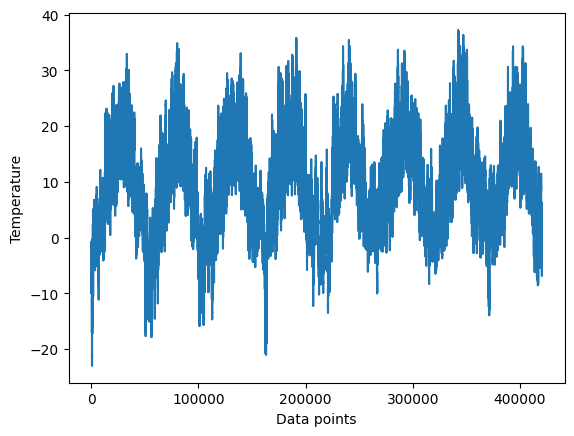

In [25]:
#Plotting the temperature timeseries
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)
plt.xlabel('Data points')
plt.ylabel('Temperature')

Text(0, 0.5, 'Temperature')

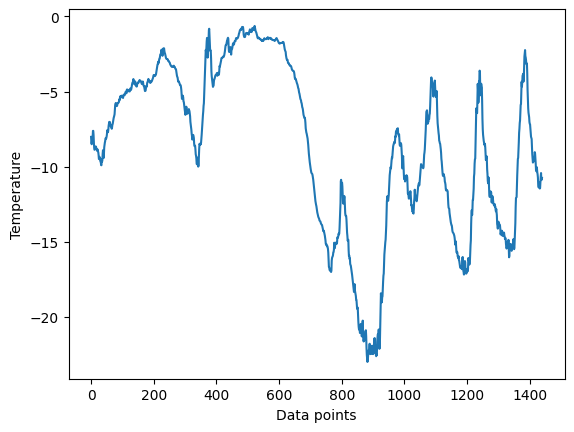

In [26]:
#Plotting the temperature timeseries for first 10 days - We will have 1440 data points
plt.plot(range(1440), temperature[:1440])
plt.xlabel('Data points')
plt.ylabel('Temperature')

In [27]:
#Number Of Sample We Will Use
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


In [28]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [29]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


In [30]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

In [31]:
#Inspecting the output of our dataset
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


### ***Model_Naive_Method***

In [32]:
#Common sense , Non-machine-learning baseline
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


### ***Model_Basic_Machinelearning_Denselayer***

In [33]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [34]:
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)]

In [35]:
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

In [36]:
history = model.fit(train_dataset, epochs=20,
                    validation_data = val_dataset, callbacks=callbacks)

Epoch 1/20
819/819 [==============================] - 9s 11ms/step - loss: 11.5438 - mae: 2.6444 - val_loss: 14.3380 - val_mae: 3.0121
Epoch 2/20
819/819 [==============================] - 9s 10ms/step - loss: 8.8636 - mae: 2.3381 - val_loss: 13.7102 - val_mae: 2.9498
Epoch 3/20
819/819 [==============================] - 9s 11ms/step - loss: 8.1704 - mae: 2.2458 - val_loss: 11.0109 - val_mae: 2.6150
Epoch 4/20
819/819 [==============================] - 9s 11ms/step - loss: 7.7771 - mae: 2.1926 - val_loss: 10.0900 - val_mae: 2.4997
Epoch 5/20
819/819 [==============================] - 9s 10ms/step - loss: 7.5066 - mae: 2.1538 - val_loss: 12.9449 - val_mae: 2.8519
Epoch 6/20
819/819 [==============================] - 9s 11ms/step - loss: 7.2566 - mae: 2.1199 - val_loss: 10.9611 - val_mae: 2.6143
Epoch 7/20
819/819 [==============================] - 9s 11ms/step - loss: 7.0844 - mae: 2.0969 - val_loss: 12.6862 - val_mae: 2.8100
Epoch 8/20
819/819 [==============================] - 9s 11ms

In [37]:
model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 4s 8ms/step - loss: 11.0207 - mae: 2.6193
Test MAE: 2.62


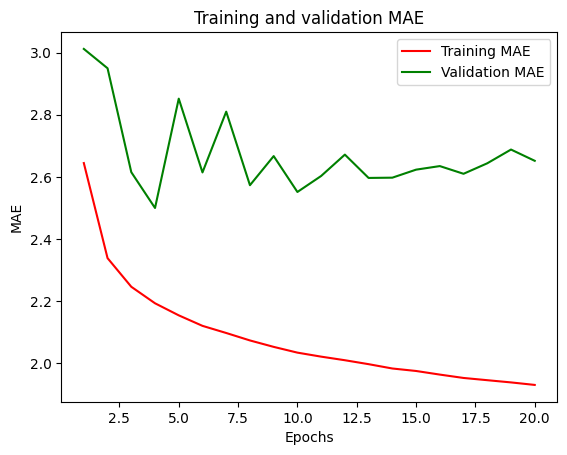

In [38]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="Red", label="Training MAE")
plt.plot(epochs,  val_loss, color="Green", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

### ***Model_1Dconvolutional_model***

In [39]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=20,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/20
819/819 [==============================] - 16s 18ms/step - loss: 20.9265 - mae: 3.5809 - val_loss: 14.7534 - val_mae: 3.0324
Epoch 2/20
819/819 [==============================] - 14s 17ms/step - loss: 14.8520 - mae: 3.0553 - val_loss: 14.5100 - val_mae: 3.0044
Epoch 3/20
819/819 [==============================] - 14s 17ms/step - loss: 13.7615 - mae: 2.9393 - val_loss: 15.7783 - val_mae: 3.1362
Epoch 4/20
819/819 [==============================] - 15s 18ms/step - loss: 13.0119 - mae: 2.8556 - val_loss: 13.9897 - val_mae: 2.9603
Epoch 5/20
819/819 [==============================] - 14s 18ms/step - loss: 12.3707 - mae: 2.7825 - val_loss: 14.6134 - val_mae: 3.0003
Epoch 6/20
819/819 [==============================] - 15s 18ms/step - loss: 11.9098 - mae: 2.7270 - val_loss: 15.0966 - val_mae: 3.0805
Epoch 7/20
819/819 [==============================] - 14s 17ms/step - loss: 11.5203 - mae: 2.6834 - val_loss: 16.4158 - val_mae: 3.1764
Epoch 8/20
819/819 [============================

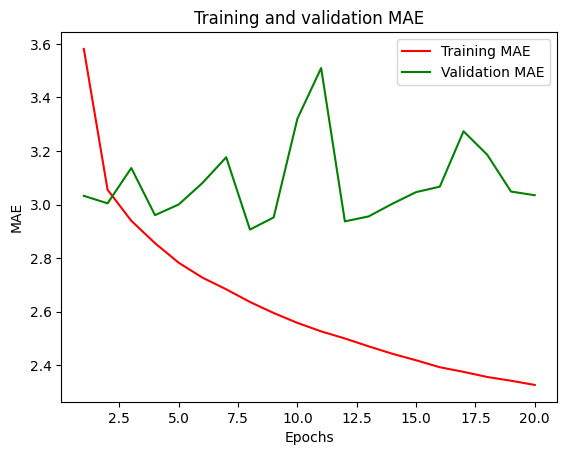

In [40]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="Red", label="Training MAE")
plt.plot(epochs,  val_loss, color= "Green", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

### ***Model_Simple_RNN***

In [41]:
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_SimRNN.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=20,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_SimRNN.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/20
819/819 [==============================] - 21s 24ms/step - loss: 138.9615 - mae: 9.7128 - val_loss: 144.1338 - val_mae: 9.9151
Epoch 2/20
819/819 [==============================] - 20s 24ms/step - loss: 136.4083 - mae: 9.5609 - val_loss: 143.7778 - val_mae: 9.8786
Epoch 3/20
819/819 [==============================] - 20s 24ms/step - loss: 136.2565 - mae: 9.5487 - val_loss: 143.6182 - val_mae: 9.8607
Epoch 4/20
819/819 [==============================] - 19s 24ms/step - loss: 136.1900 - mae: 9.5414 - val_loss: 143.5909 - val_mae: 9.8570
Epoch 5/20
819/819 [==============================] - 20s 24ms/step - loss: 136.1655 - mae: 9.5382 - val_loss: 143.5734 - val_mae: 9.8544
Epoch 6/20
819/819 [==============================] - 20s 24ms/step - loss: 136.1237 - mae: 9.5336 - val_loss: 143.5241 - val_mae: 9.8487
Epoch 7/20
819/819 [==============================] - 20s 24ms/step - loss: 136.0946 - mae: 9.5301 - val_loss: 143.5450 - val_mae: 9.8516
Epoch 8/20
819/819 [==============

### ***Model_Simple RNN_Stackinglayers***

In [42]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_SRNN2.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=20,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_SRNN2.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")


Epoch 1/20
819/819 [==============================] - 62s 73ms/step - loss: 136.7604 - mae: 9.5633 - val_loss: 143.4109 - val_mae: 9.8353
Epoch 2/20
819/819 [==============================] - 62s 75ms/step - loss: 135.9517 - mae: 9.5131 - val_loss: 143.3788 - val_mae: 9.8324
Epoch 3/20
819/819 [==============================] - 60s 73ms/step - loss: 135.9078 - mae: 9.5080 - val_loss: 143.3967 - val_mae: 9.8348
Epoch 4/20
819/819 [==============================] - 61s 75ms/step - loss: 135.8712 - mae: 9.5037 - val_loss: 143.4348 - val_mae: 9.8388
Epoch 5/20
819/819 [==============================] - 61s 75ms/step - loss: 135.8661 - mae: 9.5020 - val_loss: 143.3924 - val_mae: 9.8334
Epoch 6/20
819/819 [==============================] - 61s 75ms/step - loss: 135.8464 - mae: 9.4979 - val_loss: 143.3826 - val_mae: 9.8301
Epoch 7/20
819/819 [==============================] - 59s 72ms/step - loss: 135.8307 - mae: 9.4963 - val_loss: 143.4061 - val_mae: 9.8350
Epoch 8/20
819/819 [==============

### ***Model_Simple_GRU***

In [43]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_gru.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=20,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_gru.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/20
819/819 [==============================] - 49s 58ms/step - loss: 37.2226 - mae: 4.4295 - val_loss: 12.6452 - val_mae: 2.6809
Epoch 2/20
819/819 [==============================] - 49s 60ms/step - loss: 10.5325 - mae: 2.5271 - val_loss: 10.2386 - val_mae: 2.4494
Epoch 3/20
819/819 [==============================] - 48s 59ms/step - loss: 9.6542 - mae: 2.4310 - val_loss: 10.3498 - val_mae: 2.4529
Epoch 4/20
819/819 [==============================] - 49s 60ms/step - loss: 9.2940 - mae: 2.3822 - val_loss: 9.4962 - val_mae: 2.3710
Epoch 5/20
819/819 [==============================] - 43s 52ms/step - loss: 9.0619 - mae: 2.3486 - val_loss: 9.9985 - val_mae: 2.4035
Epoch 6/20
819/819 [==============================] - 48s 59ms/step - loss: 8.8686 - mae: 2.3218 - val_loss: 10.2618 - val_mae: 2.4241
Epoch 7/20
819/819 [==============================] - 47s 57ms/step - loss: 8.6746 - mae: 2.2960 - val_loss: 10.5685 - val_mae: 2.4420
Epoch 8/20
819/819 [==============================] - 4

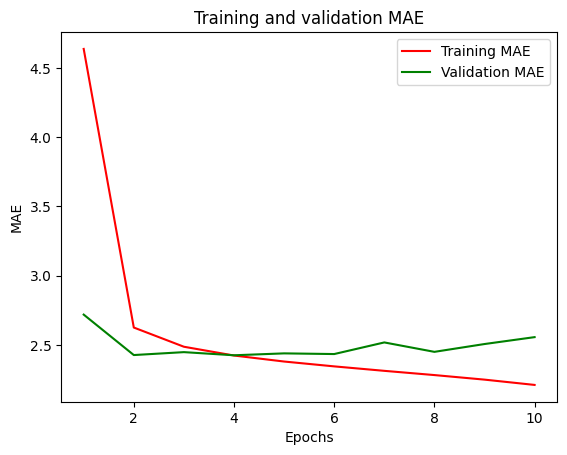

In [72]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="Red", label="Training MAE")
plt.plot(epochs,  val_loss, color="Green", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

### ***Model_Simple_LSTM***

In [45]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=20,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/20
819/819 [==============================] - 50s 59ms/step - loss: 46.1116 - mae: 4.9691 - val_loss: 13.3516 - val_mae: 2.7705
Epoch 2/20
819/819 [==============================] - 51s 62ms/step - loss: 11.6228 - mae: 2.6368 - val_loss: 9.9315 - val_mae: 2.4483
Epoch 3/20
819/819 [==============================] - 48s 58ms/step - loss: 10.1482 - mae: 2.4811 - val_loss: 10.0982 - val_mae: 2.4827
Epoch 4/20
819/819 [==============================] - 52s 63ms/step - loss: 9.5712 - mae: 2.4105 - val_loss: 10.0145 - val_mae: 2.4736
Epoch 5/20
819/819 [==============================] - 52s 63ms/step - loss: 9.0953 - mae: 2.3515 - val_loss: 10.4017 - val_mae: 2.4976
Epoch 6/20
819/819 [==============================] - 50s 61ms/step - loss: 8.7304 - mae: 2.3059 - val_loss: 10.4056 - val_mae: 2.5069
Epoch 7/20
819/819 [==============================] - 48s 59ms/step - loss: 8.3895 - mae: 2.2593 - val_loss: 10.7626 - val_mae: 2.5476
Epoch 8/20
819/819 [==============================] -

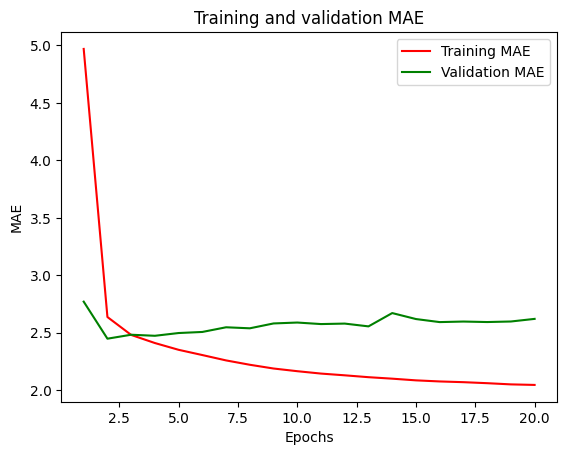

In [46]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="Red", label="Training MAE")
plt.plot(epochs,  val_loss, color="Green", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

### ***Model_LSTM_withDropout***

In [47]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.6)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=20,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/20
819/819 [==============================] - 67s 80ms/step - loss: 56.9304 - mae: 5.6648 - val_loss: 15.5209 - val_mae: 2.9494
Epoch 2/20
819/819 [==============================] - 66s 80ms/step - loss: 23.9712 - mae: 3.7396 - val_loss: 10.4378 - val_mae: 2.5108
Epoch 3/20
819/819 [==============================] - 67s 81ms/step - loss: 21.3723 - mae: 3.5354 - val_loss: 10.0793 - val_mae: 2.4798
Epoch 4/20
819/819 [==============================] - 66s 80ms/step - loss: 20.3310 - mae: 3.4510 - val_loss: 9.9328 - val_mae: 2.4621
Epoch 5/20
819/819 [==============================] - 67s 81ms/step - loss: 19.5288 - mae: 3.3795 - val_loss: 10.1440 - val_mae: 2.4889
Epoch 6/20
819/819 [==============================] - 64s 78ms/step - loss: 18.8273 - mae: 3.3297 - val_loss: 9.6405 - val_mae: 2.4311
Epoch 7/20
819/819 [==============================] - 65s 80ms/step - loss: 18.2941 - mae: 3.2824 - val_loss: 9.6719 - val_mae: 2.4373
Epoch 8/20
819/819 [==============================]

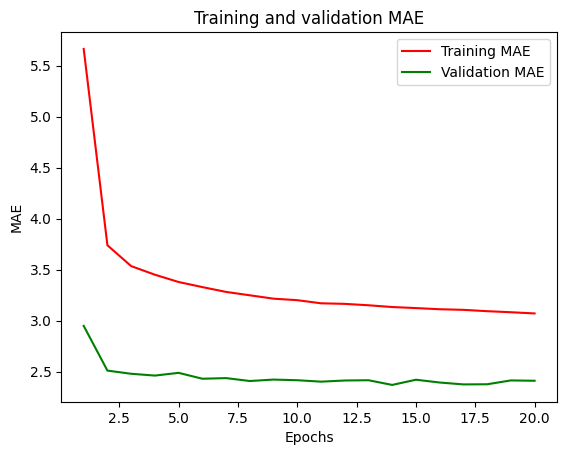

In [48]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="Red", label="Training MAE")
plt.plot(epochs,  val_loss, color="Green", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

In [76]:
import numpy as np
import pandas as pd
from IPython.display import display

Models = ("Model_Naive_Method","Model_Basic_Machinelearning_Denselayer","Model_1Dconvolutional_model","Model_Simple_RNN","Model_Simple_RNN","Model_Simple_GRU","Model_Simple_LSTM","Model_LSTM_withDropout")
Test_MAE = (2.62,2.62,3.09,9.91,9.92,2.47,2.56,2.57)

# Create a DataFrame
df = pd.DataFrame({
    'Model': Models,
    'Test_MAE': Test_MAE
})

# Find the row with the highest accuracy
min_MAE_index = df['Test_MAE'].idxmin()

# Highlight the row with the highest accuracy
def highlight_max(s):
    is_max = s == s.min()
    return ['background-color: yellow' if v else '' for v in is_max]

# Apply the highlight function
df_styled = df.style.apply(highlight_max, subset=['Test_MAE'])

# Display the styled DataFrame
display(df_styled)

,Model,Test_MAE
0,Model_Naive_Method,2.620000
1,Model_Basic_Machinelearning_Denselayer,2.620000
2,Model_1Dconvolutional_model,3.090000
3,Model_Simple_RNN,9.910000
4,Model_Simple_RNN,9.920000
5,Model_Simple_GRU,2.470000
6,Model_Simple_LSTM,2.560000
7,Model_LSTM_withDropout,2.570000


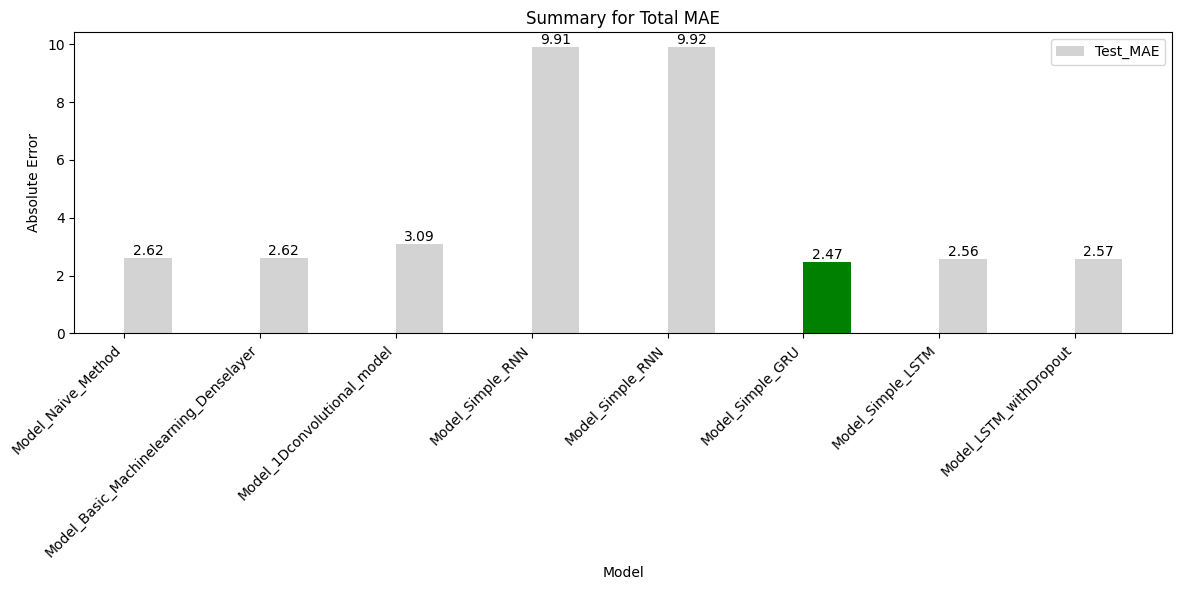

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming results_M11, results_M12, etc. are defined elsewhere in your code
Models = ("Model_Naive_Method","Model_Basic_Machinelearning_Denselayer","Model_1Dconvolutional_model","Model_Simple_RNN","Model_Simple_RNN","Model_Simple_GRU","Model_Simple_LSTM","Model_LSTM_withDropout")
Test_MAE = (2.62,2.62,3.09,9.91,9.92,2.47,2.56,2.57)


# Create a DataFrame
df = pd.DataFrame({
    'Model': Models,
    'Test_MAE': Test_MAE
})

# Find the indices of the highest accuracy and lowest loss
min_MAE_index = df['Test_MAE'].idxmin()

# Create a grouped bar graph
fig, ax = plt.subplots(figsize=(12, 6))

# Set colors: dark gray for accuracy, light gray for loss, red for lowest loss, green for highest accuracy
colors_MAE = ['lightgray'] * len(df)
colors_MAE[min_MAE_index] = 'Green'

# Plot the bars
bar_width = 0.35
index = np.arange(len(df))

bars2 = ax.bar(index + bar_width, df['Test_MAE'], bar_width, label='Test_MAE', color=colors_MAE)

# Annotate the bars with the accuracy and loss values
for bar, Test_MAE in zip(bars2, df['Test_MAE']):
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, round(Test_MAE, 2), va='bottom', ha='center')  # va: vertical alignment

# Add labels and title
plt.title("Summary for Total MAE")
plt.ylabel("Absolute Error")
plt.xlabel("Model")
plt.xticks(index + bar_width / 2, df['Model'], rotation=45, ha='right')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

# ***Task 1 : 1.Adjusting the number of units in each recurrent layer in the stacked setup and Using LSTM instead of GRU***

### ***Model_LSTM_Stacked_with16units***

In [54]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16, return_sequences=True)(inputs)
x = layers.LSTM(16)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked1.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=20,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_LSTM_stacked1.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/20
819/819 [==============================] - 98s 115ms/step - loss: 34.2760 - mae: 4.2221 - val_loss: 11.5284 - val_mae: 2.5959
Epoch 2/20
819/819 [==============================] - 101s 123ms/step - loss: 10.1279 - mae: 2.4674 - val_loss: 10.3781 - val_mae: 2.5014
Epoch 3/20
819/819 [==============================] - 96s 117ms/step - loss: 8.9673 - mae: 2.3277 - val_loss: 10.3679 - val_mae: 2.5127
Epoch 4/20
819/819 [==============================] - 103s 126ms/step - loss: 8.3838 - mae: 2.2507 - val_loss: 10.0510 - val_mae: 2.4843
Epoch 5/20
819/819 [==============================] - 98s 119ms/step - loss: 7.9308 - mae: 2.1893 - val_loss: 10.2538 - val_mae: 2.4971
Epoch 6/20
819/819 [==============================] - 91s 111ms/step - loss: 7.5469 - mae: 2.1376 - val_loss: 10.4664 - val_mae: 2.5310
Epoch 7/20
819/819 [==============================] - 96s 117ms/step - loss: 7.2600 - mae: 2.0953 - val_loss: 10.5195 - val_mae: 2.5385
Epoch 8/20
819/819 [========================

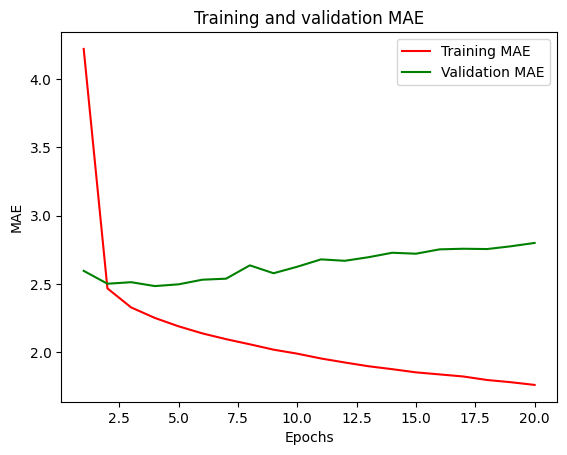

In [55]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="Red", label="Training MAE")
plt.plot(epochs,  val_loss, color="Green", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

### ***Model_LSTM_Stacked_with64units***

In [68]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16, return_sequences=True)(inputs)
x = layers.LSTM(64)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked2.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_LSTM_stacked2.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 204s 245ms/step - loss: 16.7413 - mae: 3.0383 - val_loss: 9.3713 - val_mae: 2.3880
Epoch 2/10
819/819 [==============================] - 196s 240ms/step - loss: 8.5103 - mae: 2.2735 - val_loss: 10.4106 - val_mae: 2.5293
Epoch 3/10
819/819 [==============================] - 201s 245ms/step - loss: 6.7152 - mae: 2.0155 - val_loss: 10.9959 - val_mae: 2.5927
Epoch 4/10
819/819 [==============================] - 200s 244ms/step - loss: 5.2396 - mae: 1.7689 - val_loss: 11.7374 - val_mae: 2.6874
Epoch 5/10
819/819 [==============================] - 197s 240ms/step - loss: 4.3054 - mae: 1.5975 - val_loss: 12.1901 - val_mae: 2.7515
Epoch 6/10
819/819 [==============================] - 198s 242ms/step - loss: 3.6772 - mae: 1.4706 - val_loss: 12.8736 - val_mae: 2.8242
Epoch 7/10
819/819 [==============================] - 198s 241ms/step - loss: 3.1501 - mae: 1.3611 - val_loss: 12.7505 - val_mae: 2.8041
Epoch 8/10
819/819 [=====================

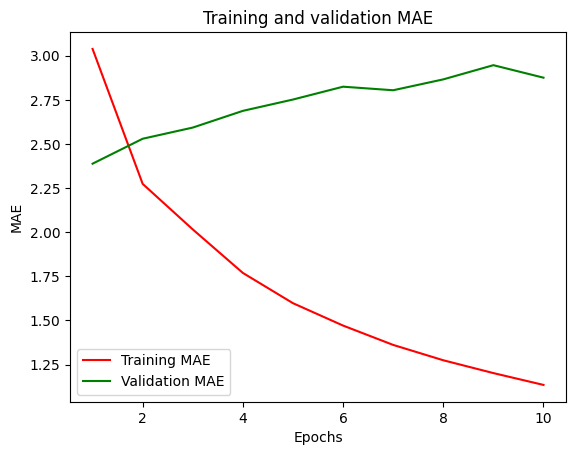

In [69]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="Red", label="Training MAE")
plt.plot(epochs,  val_loss, color="Green", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

### ***Model_LSTM_Stacked_with8&16units***

In [70]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(8, return_sequences=True)(inputs)
x = layers.LSTM(16)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM_stacked3.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_LSTM_stacked3.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 91s 106ms/step - loss: 40.2411 - mae: 4.6375 - val_loss: 12.7911 - val_mae: 2.7192
Epoch 2/10
819/819 [==============================] - 91s 111ms/step - loss: 11.3411 - mae: 2.6259 - val_loss: 9.8077 - val_mae: 2.4272
Epoch 3/10
819/819 [==============================] - 83s 101ms/step - loss: 10.1579 - mae: 2.4872 - val_loss: 10.0052 - val_mae: 2.4482
Epoch 4/10
819/819 [==============================] - 88s 107ms/step - loss: 9.6914 - mae: 2.4237 - val_loss: 9.7620 - val_mae: 2.4256
Epoch 5/10
819/819 [==============================] - 85s 104ms/step - loss: 9.3681 - mae: 2.3804 - val_loss: 9.9544 - val_mae: 2.4392
Epoch 6/10
819/819 [==============================] - 85s 104ms/step - loss: 9.0921 - mae: 2.3453 - val_loss: 9.9066 - val_mae: 2.4344
Epoch 7/10
819/819 [==============================] - 84s 102ms/step - loss: 8.8280 - mae: 2.3132 - val_loss: 10.6331 - val_mae: 2.5183
Epoch 8/10
819/819 [=============================

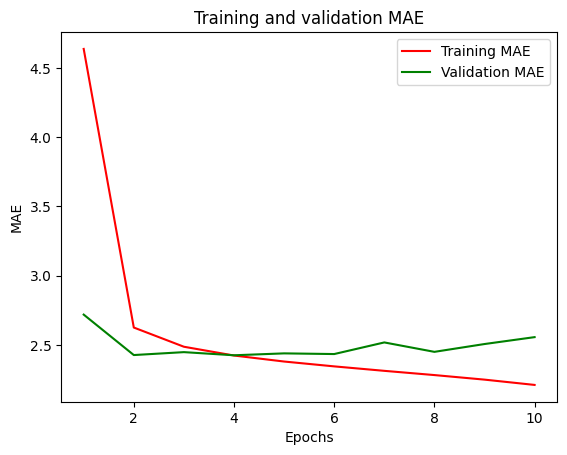

In [71]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="Red", label="Training MAE")
plt.plot(epochs,  val_loss, color="Green", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

# ***Trying to Improve the result by using technique Dropuout regularization, Building Bidirectional LSTM.***

### ***Model_LSTM_dropoutregularized_stacked_model_with8units***

In [64]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(8, recurrent_dropout=0.2, return_sequences=True)(inputs)
x = layers.LSTM(8, recurrent_dropout=0.2)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_LSTM_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_LSTM_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 122s 143ms/step - loss: 79.4428 - mae: 6.9034 - val_loss: 40.6873 - val_mae: 4.7903
Epoch 2/10
819/819 [==============================] - 118s 144ms/step - loss: 33.8417 - mae: 4.3466 - val_loss: 14.8612 - val_mae: 2.8656
Epoch 3/10
819/819 [==============================] - 119s 145ms/step - loss: 24.3219 - mae: 3.7324 - val_loss: 10.9714 - val_mae: 2.5342
Epoch 4/10
819/819 [==============================] - 119s 145ms/step - loss: 22.2712 - mae: 3.5795 - val_loss: 10.2414 - val_mae: 2.4664
Epoch 5/10
819/819 [==============================] - 118s 144ms/step - loss: 21.0830 - mae: 3.4817 - val_loss: 9.8406 - val_mae: 2.4245
Epoch 6/10
819/819 [==============================] - 119s 145ms/step - loss: 20.0411 - mae: 3.3966 - val_loss: 9.8704 - val_mae: 2.4283
Epoch 7/10
819/819 [==============================] - 118s 144ms/step - loss: 19.2774 - mae: 3.3300 - val_loss: 9.4387 - val_mae: 2.3824
Epoch 8/10
819/819 [=================

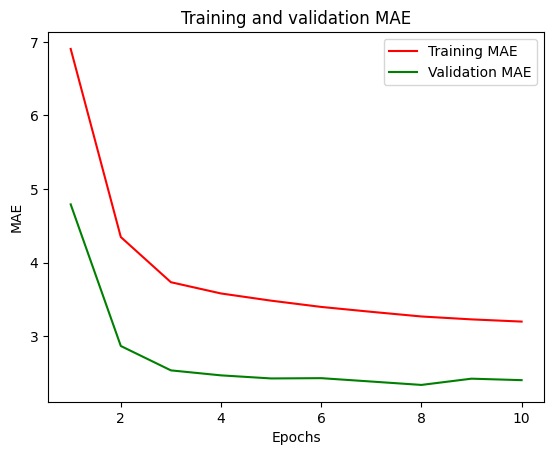

In [65]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="Red", label="Training MAE")
plt.plot(epochs,  val_loss, color="Green", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

### ***Model_Bidirectional_LSTM***

In [58]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(8))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_bidirec_LSTM.keras",
                                    save_best_only=True)
]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                     callbacks=callbacks)

model = keras.models.load_model("jena_bidirec_LSTM.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")


Epoch 1/10
819/819 [==============================] - 51s 58ms/step - loss: 47.7397 - mae: 5.0836 - val_loss: 14.0449 - val_mae: 2.8498
Epoch 2/10
819/819 [==============================] - 47s 57ms/step - loss: 12.1309 - mae: 2.7237 - val_loss: 10.4146 - val_mae: 2.5011
Epoch 3/10
819/819 [==============================] - 48s 58ms/step - loss: 10.1455 - mae: 2.4918 - val_loss: 9.8107 - val_mae: 2.4304
Epoch 4/10
819/819 [==============================] - 47s 57ms/step - loss: 9.6068 - mae: 2.4170 - val_loss: 9.7976 - val_mae: 2.4155
Epoch 5/10
819/819 [==============================] - 46s 56ms/step - loss: 9.3200 - mae: 2.3763 - val_loss: 9.4514 - val_mae: 2.3685
Epoch 6/10
819/819 [==============================] - 48s 58ms/step - loss: 9.1157 - mae: 2.3496 - val_loss: 9.6491 - val_mae: 2.3843
Epoch 7/10
819/819 [==============================] - 46s 56ms/step - loss: 8.9075 - mae: 2.3251 - val_loss: 9.3927 - val_mae: 2.3594
Epoch 8/10
819/819 [==============================] - 48s

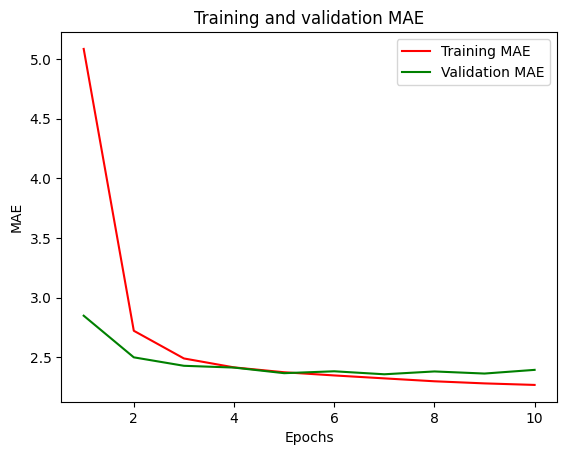

In [59]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="Red", label="Training MAE")
plt.plot(epochs,  val_loss, color="Green", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

# ***1D Convnets and RNN togther***

### ***Model_1DConvents_RNNTogether***



In [62]:

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(64, 3, activation='relu')(inputs)
x = layers.MaxPooling1D(3)(x)
x = layers.Conv1D(128, 3, activation='relu')(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Reshape((-1, 128))(x)
x = layers.LSTM(16)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_Conv_LSTM.keras", save_best_only=True)
]

history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=callbacks)

model = keras.models.load_model("jena_Conv_LSTM.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 17s 18ms/step - loss: 43.0932 - mae: 4.8907 - val_loss: 24.9237 - val_mae: 3.8679
Epoch 2/10
819/819 [==============================] - 14s 17ms/step - loss: 16.8958 - mae: 3.1761 - val_loss: 22.2702 - val_mae: 3.7297
Epoch 3/10
819/819 [==============================] - 14s 17ms/step - loss: 14.0247 - mae: 2.9070 - val_loss: 24.0642 - val_mae: 3.8630
Epoch 4/10
819/819 [==============================] - 14s 17ms/step - loss: 12.4534 - mae: 2.7325 - val_loss: 21.7950 - val_mae: 3.7485
Epoch 5/10
819/819 [==============================] - 14s 17ms/step - loss: 11.3511 - mae: 2.5996 - val_loss: 23.4815 - val_mae: 3.8381
Epoch 6/10
819/819 [==============================] - 14s 17ms/step - loss: 10.5287 - mae: 2.4966 - val_loss: 23.8831 - val_mae: 3.8986
Epoch 7/10
819/819 [==============================] - 14s 17ms/step - loss: 9.8427 - mae: 2.4064 - val_loss: 26.3202 - val_mae: 4.0377
Epoch 8/10
819/819 [=============================

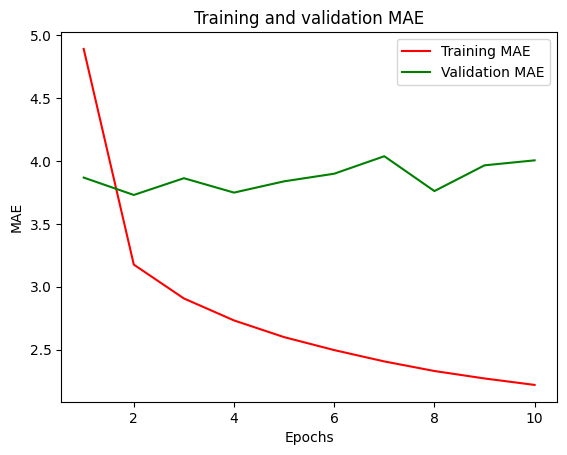

In [63]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, color="Red", label="Training MAE")
plt.plot(epochs,  val_loss, color="Green", label="Validation MAE")
plt.title("Training and validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

In [75]:
import numpy as np
import pandas as pd
from IPython.display import display

Models = ("Model_LSTM_Stacked_with16units","Model_LSTM_Stacked_with8_16units","Model_LSTM_Stacked_with_16_64units","Model_LSTM_dropoutregularized_stacked_model_with8units","Model_Bidirectional_LSTM","Model_1DConvents_RNNTogether")
Test_MAE = (2.63,2.51,2.56,2.58,2.56,3.88)

# Create a DataFrame
df = pd.DataFrame({
    'Model': Models,
    'Test_MAE': Test_MAE
})

# Find the row with the highest accuracy
min_MAE_index = df['Test_MAE'].idxmin()

# Highlight the row with the highest accuracy
def highlight_max(s):
    is_max = s == s.min()
    return ['background-color: yellow' if v else '' for v in is_max]

# Apply the highlight function
df_styled = df.style.apply(highlight_max, subset=['Test_MAE'])

# Display the styled DataFrame
display(df_styled)

,Model,Test_MAE
0,Model_LSTM_Stacked_with16units,2.630000
1,Model_LSTM_Stacked_with8_16units,2.510000
2,Model_LSTM_Stacked_with_16_64units,2.560000
3,Model_LSTM_dropoutregularized_stacked_model_with8units,2.580000
4,Model_Bidirectional_LSTM,2.560000
5,Model_1DConvents_RNNTogether,3.880000


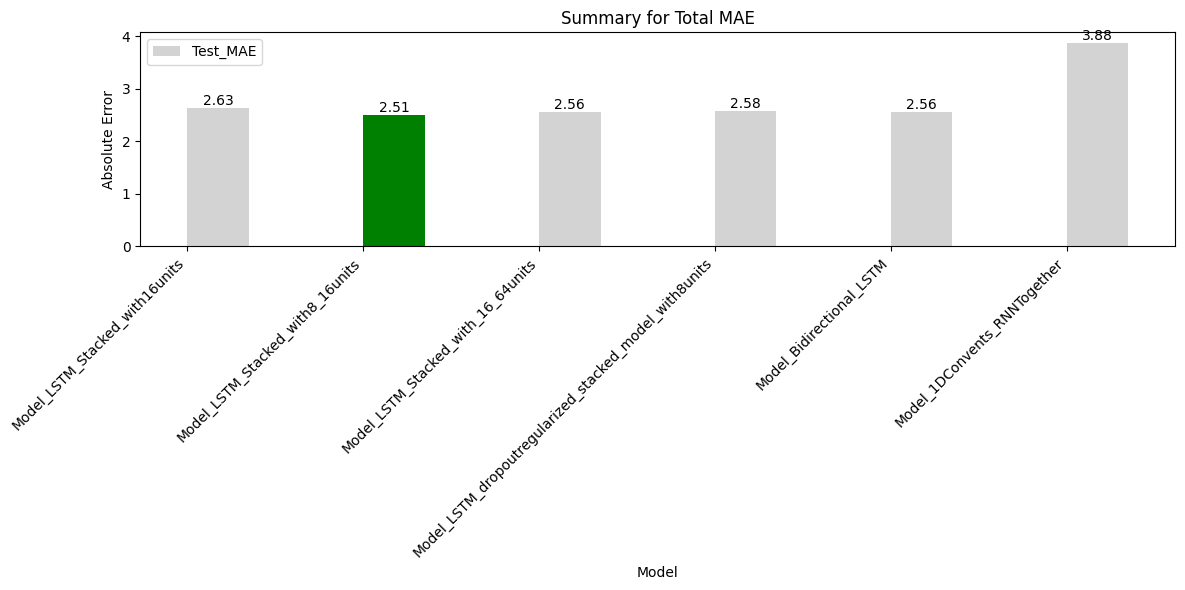

In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming results_M11, results_M12, etc. are defined elsewhere in your code
Models = ("Model_LSTM_Stacked_with16units","Model_LSTM_Stacked_with8_16units","Model_LSTM_Stacked_with_16_64units","Model_LSTM_dropoutregularized_stacked_model_with8units","Model_Bidirectional_LSTM","Model_1DConvents_RNNTogether")
Test_MAE = (2.63,2.51,2.56,2.58,2.56,3.88)


# Create a DataFrame
df = pd.DataFrame({
    'Model': Models,
    'Test_MAE': Test_MAE
})

# Find the indices of the highest accuracy and lowest loss
min_MAE_index = df['Test_MAE'].idxmin()

# Create a grouped bar graph
fig, ax = plt.subplots(figsize=(12, 6))

# Set colors: dark gray for accuracy, light gray for loss, red for lowest loss, green for highest accuracy
colors_MAE = ['lightgray'] * len(df)
colors_MAE[min_MAE_index] = 'Green'

# Plot the bars
bar_width = 0.35
index = np.arange(len(df))

bars2 = ax.bar(index + bar_width, df['Test_MAE'], bar_width, label='Test_MAE', color=colors_MAE)

# Annotate the bars with the accuracy and loss values
for bar, Test_MAE in zip(bars2, df['Test_MAE']):
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, round(Test_MAE, 2), va='bottom', ha='center')  # va: vertical alignment

# Add labels and title
plt.title("Summary for Total MAE")
plt.ylabel("Absolute Error")
plt.xlabel("Model")
plt.xticks(index + bar_width / 2, df['Model'], rotation=45, ha='right')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

# ***Please refer "Kandarp_Assignment3" PDF file for Conclusion & Recommendation***